# <span style="font-size:1.5em;">Petfinder Pawpularity Neural Network Modeling
Authors: Aisha Baitemirova-Othman, Angela Kim, Steven Addison

# Contents
<l></l>

<span style="font-size:1.2em;">

- <a href="#Overview">Overview</a>

- <a href="#Business Understanding">Business Understanding</a>  

- <a href="#Data Understanding">Data Understanding</a>  
    
- <a href="#Imports">Imports</a> 

- <a href="#Data Preparation & Analysis">Data Preparation & Analysis</a>  
    
- <a href="#Modeling">Modeling</a>
    
    - <a href="#First Basic Model and Image Augmentation">First Basic Model and Image Augmentation</a>
    
    - <a href="#Iterative Artificial Neural Network Building">Iterative Artificial Neural Network Building</a>
    
    - <a href="#Iterative Convolutional Neural Network Building">Iterative Convolutional Neural Network Building</a>
    
- <a href="#Conclusion">Conclusion</a>
    
- <a href="#Next Steps">Next Steps</a>
    
- <a href="#Sources">Sources</a>

---

# <a id="#Overview">Overview</a>

> [Petfinder.my](https://www.petfinder.my/) is Malaysia’s leading animal welfare platform, featuring over 200,000 animals with more than 56,000 happily adopted. This project analyzes photos of adoptable pets from Malaysian animal shelters found on Petfinder and designs a Deep Learning model to predict the "Pawpularity" of pet photos.

# <a id="#Business Understanding">Business Understanding</a>

>They say a picture is worth a thousand words. A picture can also save a life. Hundreds of millions of stray cats and dogs suffer on the streets, live miserably in crowded shelters, or are euthanized around the world. Companion animals with attractive and high quality photos are more likely to be adopted and more likely to be adopted faster [source](https://www.tandfonline.com/doi/full/10.1080/10888705.2014.982796). We want to answer the question: what makes a good picture? After analyzing raw images and metadata to predict the “Pawpularity” of pet photos, we train and test our model on PetFinder.my's thousands of pet profiles to come up with the best recommendations on photo composition. We hope our model will help stray cats and dogs find their "furever" home faster.

# <a id="Data Understanding">Data Understanding</a>

>The data comes from thousands of pet profiles on [Petfinder.my](https://www.petfinder.my/). The `Pawpularity` score is derived from each pet profile's page view statistics at the listing pages, using an algorithm that normalizes the traffic data across different pages, platforms (web & mobile) and various metrics. Duplicate clicks, crawler bot accesses and sponsored profiles are excluded from the analysis. All the feature metadata is explained [here](https://github.com/stevenaddison/Project-4/blob/main/data/metadata.md).
---

# <a id="Imports">Imports</a>

> First, we start with importing the relevant libraries to load and clean out our dataset.

In [1]:
#pip install opencv-python
#pip install scikit-image

In [2]:
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
import keras

from skimage.transform import resize
from skimage import color
from skimage import io

from scipy import ndimage, misc

from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error as mse

from keras import backend
from keras.applications.inception_v3 import InceptionV3
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.initializers import RandomNormal

from keras.optimizers import SGD

import matplotlib.pyplot as plt
import seaborn as sns

C:\Users\steve\anaconda3\envs\learn-env\lib\site-packages\skimage\io\manage_plugins.py:23: UserWarning: Your installed pillow version is < 8.1.2. Several security issues (CVE-2021-27921, CVE-2021-25290, CVE-2021-25291, CVE-2021-25293, and more) have been fixed in pillow 8.1.2 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper


# <a id="Data Preparation & Analysis">Data Preparation & Analysis</a>

>There are 9912 images and 12 features: `Subject Focus`, `Eyes`, `Face`, `Near`, `Action`, `Accessory`, `Group`, `Collage`, `Human`, `Occlusion`, `Info`, and `Blur` . The target variable is `Pawpularity` and ranges from 1-100. There are no null values and all features have a value of 0 (no) or 1 (yes).

In [3]:
df = pd.read_csv("data/train.csv")

In [4]:
df.head()

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9912 entries, 0 to 9911
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Id             9912 non-null   object
 1   Subject Focus  9912 non-null   int64 
 2   Eyes           9912 non-null   int64 
 3   Face           9912 non-null   int64 
 4   Near           9912 non-null   int64 
 5   Action         9912 non-null   int64 
 6   Accessory      9912 non-null   int64 
 7   Group          9912 non-null   int64 
 8   Collage        9912 non-null   int64 
 9   Human          9912 non-null   int64 
 10  Occlusion      9912 non-null   int64 
 11  Info           9912 non-null   int64 
 12  Blur           9912 non-null   int64 
 13  Pawpularity    9912 non-null   int64 
dtypes: int64(13), object(1)
memory usage: 1.1+ MB


In [6]:
df.describe()

,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
count,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000
mean,0.027643,0.772599,0.903955,0.861582,0.009988,0.067797,0.129338,0.049637,0.166263,0.172014,0.061239,0.070420,38.039044
std,0.163957,0.419175,0.294668,0.345356,0.099444,0.251409,0.335591,0.217204,0.372335,0.377411,0.239780,0.255866,20.591990
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,25.000000
50%,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,33.000000
75%,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,46.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,100.000000


In [7]:
for c in df.columns:
    print ("---- %s ----" % c)
    print (df[c].value_counts())
    print("\n")

---- Id ----
4f4c2be7b5384bd059880e653d98a583    1
b6c217bb4b9b69294a3637a2c2c22133    1
d9d4cb29d92ea2ce865b59aadee9850b    1
5bb61d8ad68f9189ab323fb70b9fc343    1
8c14c04471b4b4d57f596432ce635c82    1
                                   ..
549e5bcbda309530792f69e2235f08bf    1
63b4511f9b9e9d788c65ef6efbb2b594    1
cd3d741ac47fdfaa06fe93470452bb7b    1
473576204e385acefd02260de4bfd884    1
46c19e01c12f643b6cb97b0c3650404e    1
Name: Id, Length: 9912, dtype: int64


---- Subject Focus ----
0    9638
1     274
Name: Subject Focus, dtype: int64


---- Eyes ----
1    7658
0    2254
Name: Eyes, dtype: int64


---- Face ----
1    8960
0     952
Name: Face, dtype: int64


---- Near ----
1    8540
0    1372
Name: Near, dtype: int64


---- Action ----
0    9813
1      99
Name: Action, dtype: int64


---- Accessory ----
0    9240
1     672
Name: Accessory, dtype: int64


---- Group ----
0    8630
1    1282
Name: Group, dtype: int64


---- Collage ----
0    9420
1     492
Name: Collage, dtype: in

In [8]:
# Count of null values per column & total
display(df.isna().sum())
print('Total Null Count:', df.isna().sum().sum())

Id               0
Subject Focus    0
Eyes             0
Face             0
Near             0
Action           0
Accessory        0
Group            0
Collage          0
Human            0
Occlusion        0
Info             0
Blur             0
Pawpularity      0
dtype: int64

Total Null Count: 0


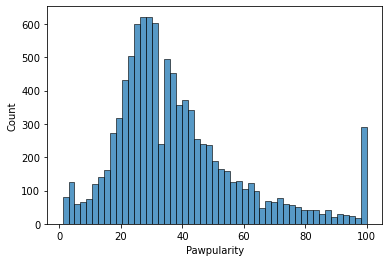

In [9]:
sns.histplot(df['Pawpularity']);

In [10]:
images = []
count = 0
for index in range(len(df)):
    Id = df.loc[index, 'Id']
    path = 'data/train/'+str(Id)+'.jpg'
    img_array = cv2.imread(path)
    img_array = resize(img_array, (64, 64), anti_aliasing=True)
    images.append(img_array)
    count += 1
    progress = (count/len(df))*100
    print('progress =', round(progress,2), '%', end='\r')

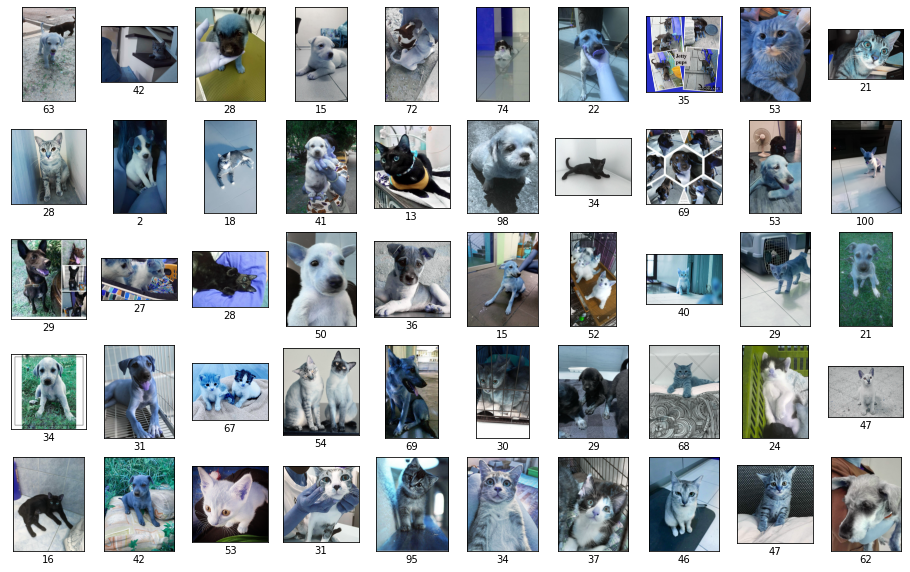

In [65]:
# Plot first 50 images
def image_read(path):
    return cv2.imread(path)

df['path'] = df.apply(lambda x : 'data/train/' + x['Id'] + ".jpg", axis=1)
fig, ax = plt.subplots(5,10,figsize=(16, 10))
for i, (path, score) in enumerate(df[['path', 'Pawpularity']][:50].values.tolist()):
    row, col = i // 10, i % 10
    axis = ax[row][col]
    axis.imshow(image_read(path))
    axis.set_xticks([])
    axis.set_yticks([])
    axis.set_xlabel(score)
plt.show()

In [22]:
len(images)

9912

In [69]:
X = np.array(images)/ 255
X.shape

(9912, 64, 64, 3)

In [25]:
X.shape

(9912, 64, 64, 3)

In [14]:
y = df['Pawpularity']

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

---

# <a id="Modeling">Modeling</a>

>Function for model evaluation

In [27]:
def model_compfit(model, X_train, y_train, n_epochs):

    # compile model with adam optimizer and mean squared error metric
    model.compile(optimizer='adam',
              loss=MeanSquaredError(),
              metrics=[RootMeanSquaredError()])
    # fit model on train sets with n number epochs
    model.fit(X_train, y_train, epochs=n_epochs)

In [28]:
def model_eval(model, X_train, y_train, X_test, y_test, name):
    
    # calculate training data metrics
    train_eval = model.evaluate(X_train, y_train)
    
    # calculate test data metrics
    test_eval = model.evaluate(X_test, y_test)
    
    # print metrics
    print(f"""
    {name} Training Metrics:
    Loss: {round(train_eval[0] , 3)}
    Root Mean Square Error: {round(train_eval[1] , 3)}
    Cross Validation Score: 
    ------
    {name} Test Metrics:
    Loss: {round(test_eval[0] , 3)}
    Root Mean Square Error: {round(test_eval[1] , 3)}
    """)
    # visualize predictions
    ypred = model.predict(X_test)
    x_ax = range(len(ypred))
    plt.figure(figsize=(20,10))
    plt.scatter(x_ax, y_test, s=15, color="blue", label="original")
    plt.plot(x_ax, ypred, lw=1, color="red", label="predicted")
    plt.legend()
    plt.show()

> Baseline Dummy Regressor

In [29]:
baseline = DummyRegressor(strategy="mean")
baseline.fit (X_train,y_train)
y_hat_test = baseline.predict(X_test)
baseline_rmse = mse(y_test, y_hat_test, squared=False)

In [30]:
baseline_rmse

21.074920522735773

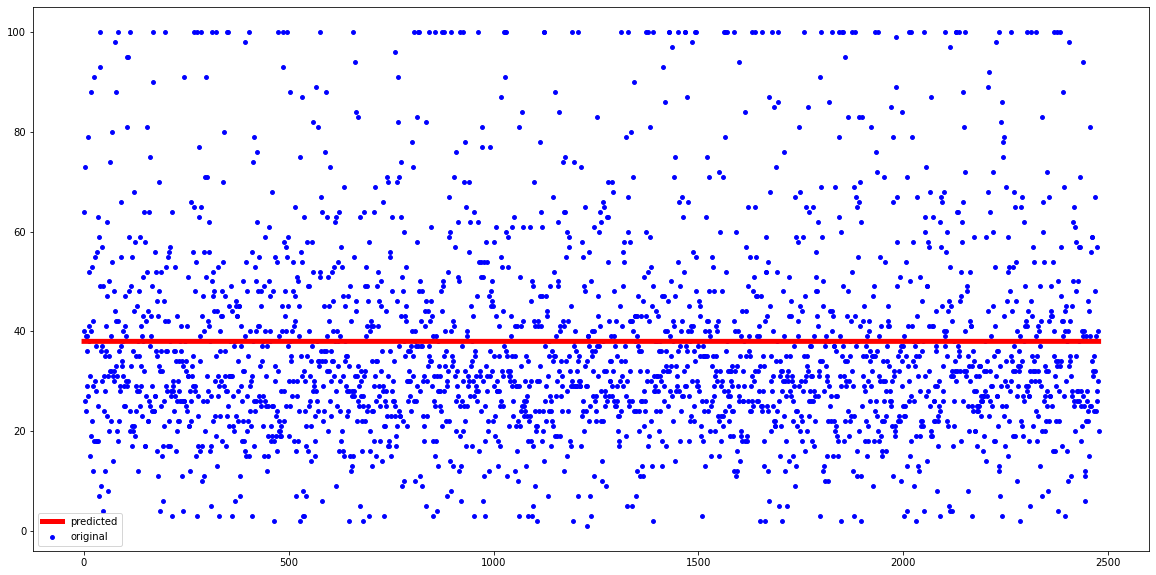

In [31]:
ypred = baseline.predict(X_test)
x_ax = range(len(ypred))
plt.figure(figsize=(20,10))
plt.scatter(x_ax, y_test, s=15, color="blue", label="original")
plt.plot(x_ax, ypred, lw=5, color="red", label="predicted")
plt.legend()
plt.show()

# <a id="First Basic Model and Image Augmentation">First Basic Model and Image Augmentation</a>

In [32]:
basicann = Sequential([
            Flatten(),
            Dense(1, activation='relu')
          ])

model_compfit(basicann, X_train, y_train, 10)

Epoch 1/10
233/233 [==============================] - 1s 3ms/step - loss: 1664.4130 - root_mean_squared_error: 40.7972
Epoch 2/10
233/233 [==============================] - 1s 3ms/step - loss: 1326.1169 - root_mean_squared_error: 36.4159
Epoch 3/10
233/233 [==============================] - 1s 3ms/step - loss: 1066.3380 - root_mean_squared_error: 32.6548
Epoch 4/10
233/233 [==============================] - 1s 3ms/step - loss: 871.2611 - root_mean_squared_error: 29.5171
Epoch 5/10
233/233 [==============================] - 1s 3ms/step - loss: 730.3131 - root_mean_squared_error: 27.0243
Epoch 6/10
233/233 [==============================] - 1s 3ms/step - loss: 632.0324 - root_mean_squared_error: 25.1403
Epoch 7/10
233/233 [==============================] - 1s 3ms/step - loss: 566.2985 - root_mean_squared_error: 23.7970
Epoch 8/10
233/233 [==============================] - 1s 3ms/step - loss: 525.1017 - root_mean_squared_error: 22.9151
Epoch 9/10
233/233 [==============================] -

78/78 [==============================] - 0s 2ms/step - loss: 506.4241 - root_mean_squared_error: 22.5039

    Basic ANN Training Metrics:
    Loss: 482.827
    Root Mean Square Error: 21.973
    Cross Validation Score: 
    ------
    Basic ANN Test Metrics:
    Loss: 506.424
    Root Mean Square Error: 22.504
    


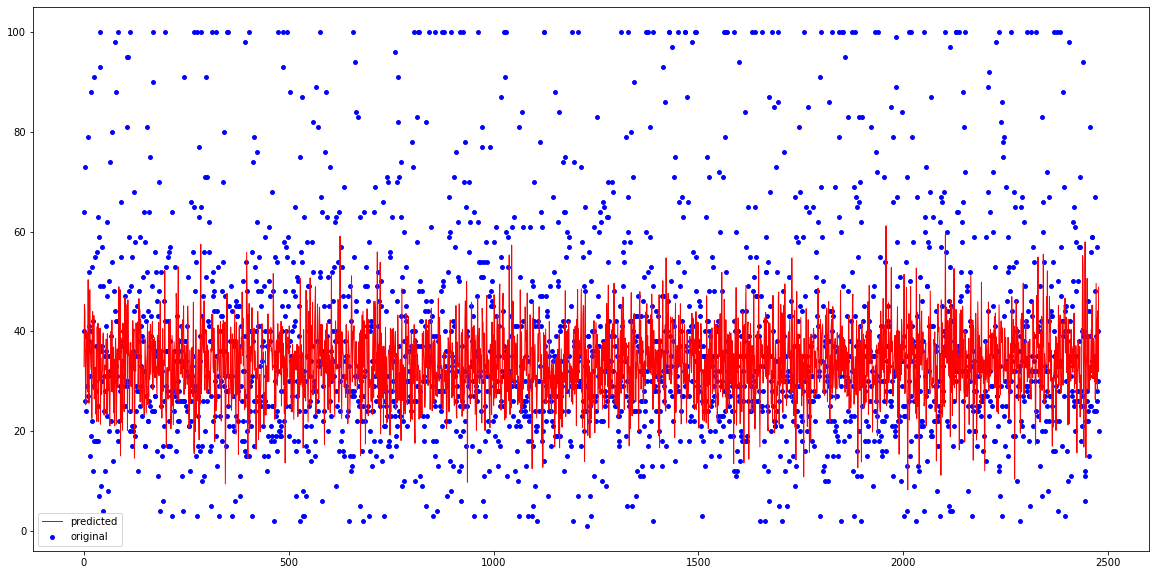

In [33]:
model_eval(basicann, X_train, y_train, X_test, y_test, 'Basic ANN')

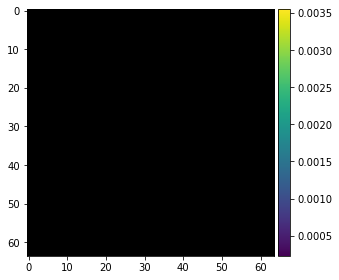

In [75]:
io.imshow(X[0])

In [73]:
X_train_grayscaled_list = []

for image in X_train:
    gray = color.rgb2gray(image)
    X_train_grayscaled_list.append(gray)
X_train_grayscaled = np.array(X_train_grayscaled_list)

In [58]:
X_train.shape

(7434, 64, 64, 3)

In [59]:
X_train_grayscaled.reshape(7434, 64, 64, 1)

array([[[[0.00336202],
         [0.00331939],
         [0.00328054],
         ...,
         [0.00311496],
         [0.00303271],
         [0.0028595 ]],

        [[0.00327859],
         [0.00328422],
         [0.00330816],
         ...,
         [0.00328796],
         [0.00327518],
         [0.00318728]],

        [[0.00308699],
         [0.0032041 ],
         [0.00328457],
         ...,
         [0.00344807],
         [0.0034246 ],
         [0.00344029]],

        ...,

        [[0.00174137],
         [0.00225721],
         [0.00225107],
         ...,
         [0.0031659 ],
         [0.00245603],
         [0.00220766]],

        [[0.00119478],
         [0.0019913 ],
         [0.00235119],
         ...,
         [0.00253533],
         [0.00195261],
         [0.00163652]],

        [[0.0006118 ],
         [0.00096318],
         [0.00186793],
         ...,
         [0.00210057],
         [0.00168055],
         [0.00147342]]],


       [[[0.00152139],
         [0.00152151],
         [0.00

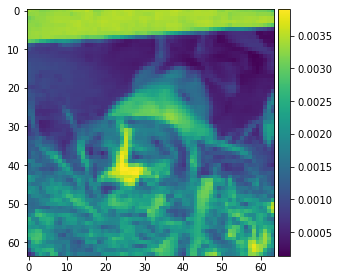

In [76]:
io.imshow(X_train_grayscaled_list[0])

In [36]:
grayann = Sequential([
            Flatten(),
            Dense(1, activation='relu')
          ])

model_compfit(grayann, X_train_grayscaled, y_train, 10)

Epoch 1/10
233/233 [==============================] - 1s 3ms/step - loss: 1792.1008 - root_mean_squared_error: 42.3332
Epoch 2/10
233/233 [==============================] - 0s 2ms/step - loss: 1643.1573 - root_mean_squared_error: 40.5359
Epoch 3/10
233/233 [==============================] - 0s 1ms/step - loss: 1511.2821 - root_mean_squared_error: 38.8752
Epoch 4/10
233/233 [==============================] - 0s 1ms/step - loss: 1391.4279 - root_mean_squared_error: 37.3018
Epoch 5/10
233/233 [==============================] - 0s 1ms/step - loss: 1282.2330 - root_mean_squared_error: 35.8083
Epoch 6/10
233/233 [==============================] - 0s 1ms/step - loss: 1182.6556 - root_mean_squared_error: 34.3898
Epoch 7/10
233/233 [==============================] - 0s 1ms/step - loss: 1092.0255 - root_mean_squared_error: 33.0458
Epoch 8/10
233/233 [==============================] - 0s 1ms/step - loss: 1009.7532 - root_mean_squared_error: 31.7766
Epoch 9/10
233/233 [============================

In [51]:
model_eval(grayann, X_train_grayscaled, y_train, X_test, y_test, 'Grayscaled ANN')

233/233 [==============================] - 0s 2ms/step - loss: 836.9554 - root_mean_squared_error: 28.9302


ValueError: in user code:

    C:\Users\steve\anaconda3\envs\learn-env\lib\site-packages\tensorflow\python\keras\engine\training.py:1224 test_function  *
        return step_function(self, iterator)
    C:\Users\steve\anaconda3\envs\learn-env\lib\site-packages\tensorflow\python\keras\engine\training.py:1215 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\steve\anaconda3\envs\learn-env\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\steve\anaconda3\envs\learn-env\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\steve\anaconda3\envs\learn-env\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\steve\anaconda3\envs\learn-env\lib\site-packages\tensorflow\python\keras\engine\training.py:1208 run_step  **
        outputs = model.test_step(data)
    C:\Users\steve\anaconda3\envs\learn-env\lib\site-packages\tensorflow\python\keras\engine\training.py:1174 test_step
        y_pred = self(x, training=False)
    C:\Users\steve\anaconda3\envs\learn-env\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:985 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    C:\Users\steve\anaconda3\envs\learn-env\lib\site-packages\tensorflow\python\keras\engine\sequential.py:372 call
        return super(Sequential, self).call(inputs, training=training, mask=mask)
    C:\Users\steve\anaconda3\envs\learn-env\lib\site-packages\tensorflow\python\keras\engine\functional.py:385 call
        return self._run_internal_graph(
    C:\Users\steve\anaconda3\envs\learn-env\lib\site-packages\tensorflow\python\keras\engine\functional.py:508 _run_internal_graph
        outputs = node.layer(*args, **kwargs)
    C:\Users\steve\anaconda3\envs\learn-env\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:975 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs,
    C:\Users\steve\anaconda3\envs\learn-env\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:212 assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer dense_1 is incompatible with the layer: expected axis -1 of input shape to have value 4096 but received input with shape [None, 12288]


In [38]:
X_train_blur = []

for image in X_train:
    image = ndimage.gaussian_filter(image, sigma= 1)
    X_train_blur.append(image)
    
X_train_blur = np.array(X_train_blur)

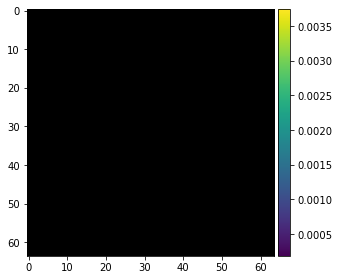

In [39]:
io.imshow(X_train_blur[0])

In [40]:
blurann = Sequential([
            Flatten(),
            Dense(1, activation='relu')
          ])

model_compfit(blurann, X_train_blur, y_train, 10)

Epoch 1/10
233/233 [==============================] - 1s 3ms/step - loss: 1663.0519 - root_mean_squared_error: 40.7805
Epoch 2/10
233/233 [==============================] - 1s 3ms/step - loss: 1325.3575 - root_mean_squared_error: 36.4055
Epoch 3/10
233/233 [==============================] - 1s 3ms/step - loss: 1065.4579 - root_mean_squared_error: 32.6414
Epoch 4/10
233/233 [==============================] - 1s 3ms/step - loss: 870.8743 - root_mean_squared_error: 29.5106
Epoch 5/10
233/233 [==============================] - 1s 3ms/step - loss: 730.0024 - root_mean_squared_error: 27.0186
Epoch 6/10
233/233 [==============================] - 1s 3ms/step - loss: 631.6205 - root_mean_squared_error: 25.1321
Epoch 7/10
233/233 [==============================] - 1s 3ms/step - loss: 566.2711 - root_mean_squared_error: 23.7965
Epoch 8/10
233/233 [==============================] - 1s 3ms/step - loss: 525.0784 - root_mean_squared_error: 22.9146
Epoch 9/10
233/233 [==============================] -

78/78 [==============================] - 0s 2ms/step - loss: 506.2819 - root_mean_squared_error: 22.5007

    Blurred ANN Training Metrics:
    Loss: 482.725
    Root Mean Square Error: 21.971
    Cross Validation Score: 
    ------
    Blurred ANN Test Metrics:
    Loss: 506.282
    Root Mean Square Error: 22.501
    


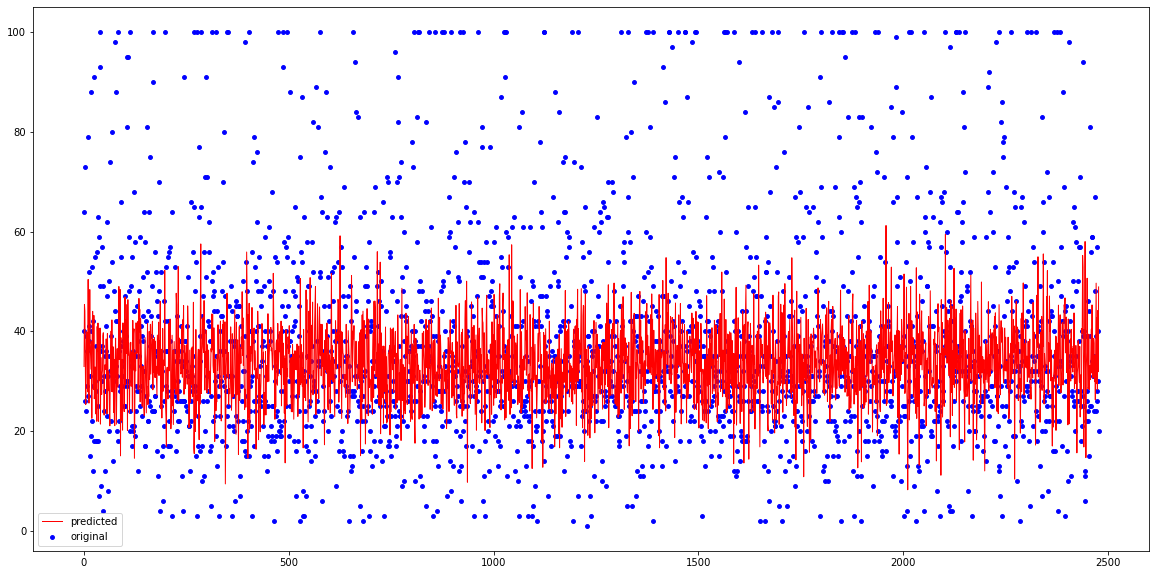

In [41]:
model_eval(blurann, X_train_blur, y_train, X_test, y_test, 'Blurred ANN')

In [42]:
X_train_flip = []

for image in X_train:
    image = cv2.flip(image,1)
    X_train_flip.append(image)
    
X_train_flip = np.array(X_train_flip)

C:\Users\steve\anaconda3\envs\learn-env\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


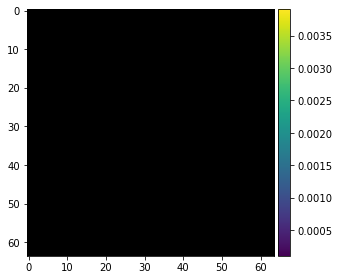

In [43]:
io.imshow(X_train_flip[0])

In [44]:
flipann = Sequential([
            Flatten(),
            Dense(1, activation='relu')
          ])

model_compfit(flipann, X_train_flip, y_train, 10)

Epoch 1/10
233/233 [==============================] - 1s 4ms/step - loss: 1663.1094 - root_mean_squared_error: 40.7812
Epoch 2/10
233/233 [==============================] - 1s 3ms/step - loss: 1325.0698 - root_mean_squared_error: 36.4015
Epoch 3/10
233/233 [==============================] - 1s 3ms/step - loss: 1065.2866 - root_mean_squared_error: 32.6387A: 0s - loss: 1120.1500 - root_mean_squared_error: 33
Epoch 4/10
233/233 [==============================] - 1s 3ms/step - loss: 871.0890 - root_mean_squared_error: 29.5142
Epoch 5/10
233/233 [==============================] - 1s 3ms/step - loss: 730.0092 - root_mean_squared_error: 27.0187
Epoch 6/10
233/233 [==============================] - 1s 4ms/step - loss: 631.4349 - root_mean_squared_error: 25.1284
Epoch 7/10
233/233 [==============================] - 1s 3ms/step - loss: 565.9615 - root_mean_squared_error: 23.7899
Epoch 8/10
233/233 [==============================] - 1s 3ms/step - loss: 524.7034 - root_mean_squared_error: 22.9064


78/78 [==============================] - 0s 3ms/step - loss: 506.3993 - root_mean_squared_error: 22.5033

    Flipped ANN Training Metrics:
    Loss: 482.812
    Root Mean Square Error: 21.973
    Cross Validation Score: 
    ------
    Flipped ANN Test Metrics:
    Loss: 506.399
    Root Mean Square Error: 22.503
    


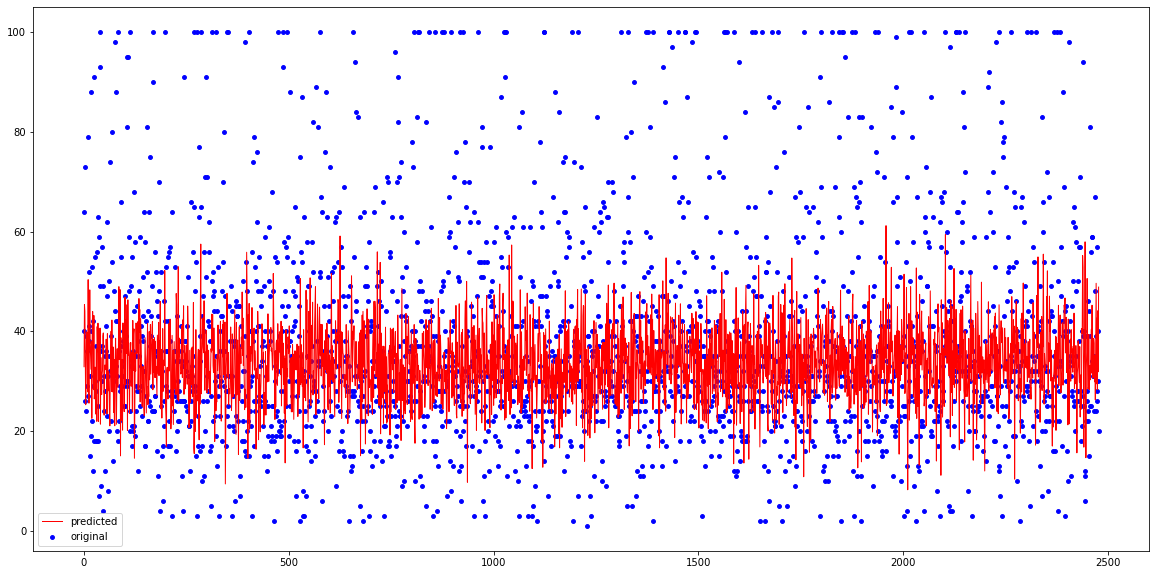

In [45]:
model_eval(flipann, X_train_flip, y_train, X_test, y_test, 'Flipped ANN')

# <a id="Iterative Artificial Neural Network Building">Iterative Artificial Neural Network Building</a>

In [46]:
ann2 = Sequential([
        Flatten(),
        Dense(1000, activation='relu'),
        Dense(1, activation='relu')
      ])

model_compfit(ann2, X_train, y_train, 10)

Epoch 1/10
233/233 [==============================] - 18s 76ms/step - loss: 658.2433 - root_mean_squared_error: 25.6563
Epoch 2/10
233/233 [==============================] - 18s 76ms/step - loss: 463.6830 - root_mean_squared_error: 21.5333
Epoch 3/10
233/233 [==============================] - 17s 75ms/step - loss: 453.7783 - root_mean_squared_error: 21.3021
Epoch 4/10
233/233 [==============================] - 18s 75ms/step - loss: 445.5694 - root_mean_squared_error: 21.1085
Epoch 5/10
233/233 [==============================] - 18s 77ms/step - loss: 438.7887 - root_mean_squared_error: 20.9473
Epoch 6/10
233/233 [==============================] - 17s 74ms/step - loss: 430.5633 - root_mean_squared_error: 20.7500
Epoch 7/10
233/233 [==============================] - 17s 74ms/step - loss: 425.4093 - root_mean_squared_error: 20.6255
Epoch 8/10
233/233 [==============================] - 17s 75ms/step - loss: 421.3915 - root_mean_squared_error: 20.5278
Epoch 9/10
233/233 [====================

78/78 [==============================] - 2s 31ms/step - loss: 446.6974 - root_mean_squared_error: 21.1352

    Second ANN Training Metrics:
    Loss: 410.779
    Root Mean Square Error: 20.268
    Cross Validation Score: 
    ------
    Second ANN Test Metrics:
    Loss: 446.697
    Root Mean Square Error: 21.135
    


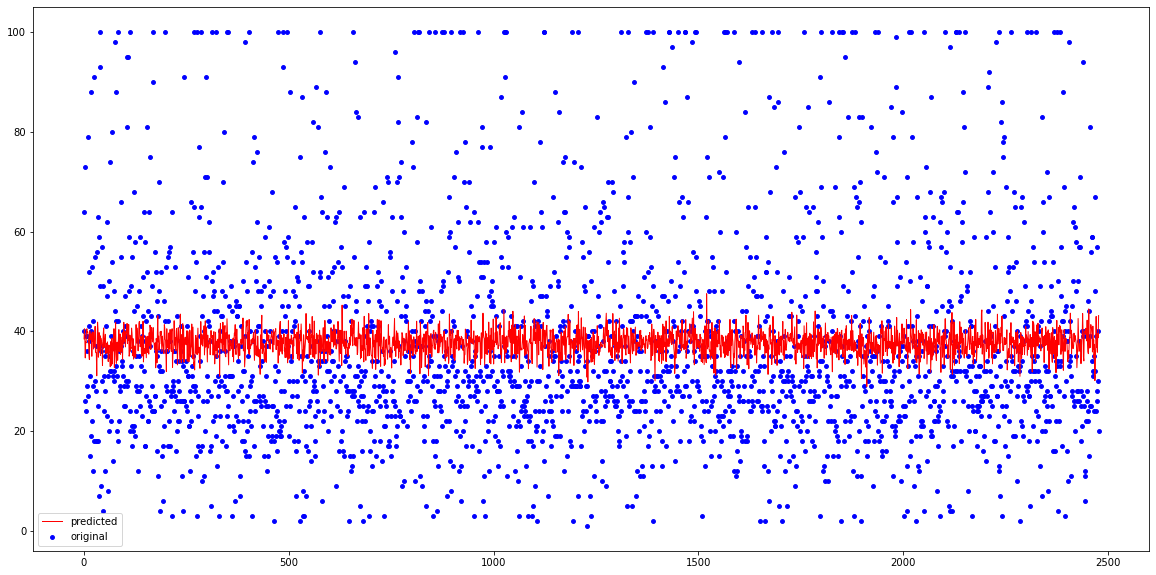

In [47]:
model_eval(ann2, X_train, y_train, X_test, y_test, 'Second ANN')

In [48]:
ann3 = Sequential([
        Flatten(),
        Dense(3000, activation='relu'),
        Dense(1000, activation='relu'),
        Dense(10, activation='relu')
      ])

model_compfit(ann3, X_train, y_train, 10)

Epoch 1/10
162/233 [===================>..........] - ETA: 29s - loss: 543.5666 - root_mean_squared_error: 23.3145

KeyboardInterrupt: 

In [ ]:
model_eval(ann3, X_train, y_train, X_test, y_test, 'Third ANN')

In [ ]:
ann4 = Sequential([
        Flatten(input_shape=(64, 64, 3)),
        Dense(units=128, activation='relu'),
        Dense(units=1, activation='relu')
])

model_compfit(ann4, X_train, y_train, 10)

In [ ]:
model_eval(ann4, X_train, y_train, X_test, y_test, 'Fourth ANN')

In [ ]:
ann5 = tf.keras.Sequential([
        Flatten(input_shape=(64, 64, 3)),
        Dense(units=128, activation='relu'),
        Dense(units=64, activation='relu'),
        Dense(units=1, activation='relu')
])

model_compfit(ann5, X_train, y_train, 10)

In [ ]:
model_eval(ann5, X_train, y_train, X_test, y_test, 'Fifth ANN')

# <a id="Iterative Convolutional Neural Network Building">Iterative Convolutional Neural Network Building</a>

In [ ]:
CNN = Sequential([
        Conv2D(32, (3, 3), activation='relu',input_shape=(64 ,64,  3)),
        MaxPooling2D((2, 2)),
        Conv2D(32, (4, 4), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(1, activation='relu'),
])

model_compfit(CNN, X_train, y_train, 10)

In [ ]:
model_eval(CNN, X_train, y_train, X_test, y_test, 'First CNN')

In [ ]:
CNN2 = Sequential([
        Conv2D(32, (3, 3), activation='relu',input_shape=(64 ,64,  3)),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(1, activation='relu'),
])

model_compfit(CNN2, X_train, y_train, 10)

In [ ]:
model_eval(CNN2, X_train, y_train, X_test, y_test, 'Second CNN')

In [ ]:
CNN3 = Sequential([
        Conv2D(32, (3, 3), activation='relu',input_shape=(64 ,64, 3)),
        MaxPooling2D((2, 2)),
        Dense(128, activation='relu'),
        Dropout(0.25),
        Dense(64, activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dropout(0.5),
        Dense(1, activation=None),
])

model_compfit(CNN3, X_train, y_train, 10)

In [ ]:
model_eval(CNN3, X_train, y_train, X_test, y_test, 'Third CNN')

---

# <a id="Conclusion">Conclusion</a>

>We found the `Pawpularity` score to be too vague to come to any strong conclusions. There wasn't much information on the Kaggle competition description that explained how the score was created and how to interpret it. We think understanding how `Pawpularity` is scored would help us prepare the data for better model results.

---

# <a id="Next Steps">Next Steps</a>

>ho ho he ho ho I am also wordS

## <a id="Sources">Sources</a>
- [Kaggle Competition Dataset](https://www.kaggle.com/c/petfinder-pawpularity-score)
- [Photo Metadata](https://github.com/stevenaddison/Project-4/blob/main/data/metadata.md)
- [Speed of Dog Adoption: Impact of Online Photo Traits](https://www.tandfonline.com/doi/full/10.1080/10888705.2014.982796)